In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch

In [2]:
# Directory containing JSON files for each project
projects_directory = "../experiments/ten_projects_experiment/results/"

# List of import patterns to store DataFrames for each project
project_dfs_codedirs = []
project_dfs_deps = []
project_dfs_imports = []

# Iterate through JSON files in the directory
for filename in os.listdir(projects_directory):
    file_path = os.path.join(projects_directory, filename)

    # Load JSON data from the file
    with open(file_path, "r") as file:
        project_data = json.load(file)

    # Extract data from the project_data
    codedirs = project_data.get("code_dirs", {})
    deps_list = project_data.get("deps_file", [])
    imports_list = project_data.get("imports", [])

    # Create a list of dictionaries of code directories
    codedirs_dicts = [
        {"code directory": key, "count": value} for key, value in codedirs.items()
    ]

    # Create a DataFrame from the list of dictionaries
    codedirs_data = pd.DataFrame(codedirs_dicts)
    codedirs_data["project_name"] = project_data.get("project_name")

    # Append the DataFrame to the list
    project_dfs_codedirs.append(codedirs_data)

    # Create a list of dictionaries of dependency declaration files
    deps_dicts = [
        {"parser_choice": dep_data["parser_choice"], "path": dep_data["path"]}
        for dep_data in deps_list
    ]

    # Create a DataFrame from the list of dictionaries
    deps_data = pd.DataFrame(deps_dicts)
    deps_data["project_name"] = project_data.get("project_name")

    # Append the DataFrame to the list
    project_dfs_deps.append(deps_data)

    # Create a list of dictionaries of imports
    def _process_import_data(import_data):
        import_type = list(import_data.keys())[0]
        # Combine primary alternative and alternative imports into a single alternative import type
        display_import_type = import_type.removesuffix(" (primary)")
        import_dict = {
            "import_type": display_import_type,
            "name": import_data[import_type]["name"],
            "lineno": import_data[import_type]["source"]["lineno"],
        }
        return import_dict

    imports_dicts = [_process_import_data(import_data) for import_data in imports_list]

    # Create a DataFrame from the list of dictionaries
    imports_data = pd.DataFrame(imports_dicts)
    imports_data["project_name"] = project_data.get("project_name")

    # Append the DataFrame to the list
    project_dfs_imports.append(imports_data)

# Combine all project DataFrames into a single DataFrame
df_codedirs = pd.concat(project_dfs_codedirs, ignore_index=True)
df_deps = pd.concat(project_dfs_deps, ignore_index=True)
df_imports = pd.concat(project_dfs_imports, ignore_index=True)

# Code directories

In [3]:
df_codedirs_max = df_codedirs.loc[df_codedirs.groupby("project_name")["count"].idxmax()]

In [4]:
df_codedirs_max

,code directory,count,project_name
35,nltk,305,nltk
12,opencv,286,opencv-python
30,pandas,425,pandas
24,packages,12453,plotly.py
18,src_py,22,pygame
10,src,18,requests
4,sklearn,308,scikit-learn
26,scipy,581,scipy
21,lib,238,sqlalchemy
0,statsmodels,770,statsmodels


In [5]:
# Divide projects into three groups by code directory patterns
same_name_projects = df_codedirs_max[
    df_codedirs_max["code directory"] == df_codedirs_max["project_name"]
]["project_name"].tolist()

src_projects = df_codedirs_max[df_codedirs_max["code directory"].str.startswith("src")][
    "project_name"
].tolist()

rest_projects = df_codedirs_max[
    ~df_codedirs_max["project_name"].isin(same_name_projects + src_projects)
]["project_name"].tolist()

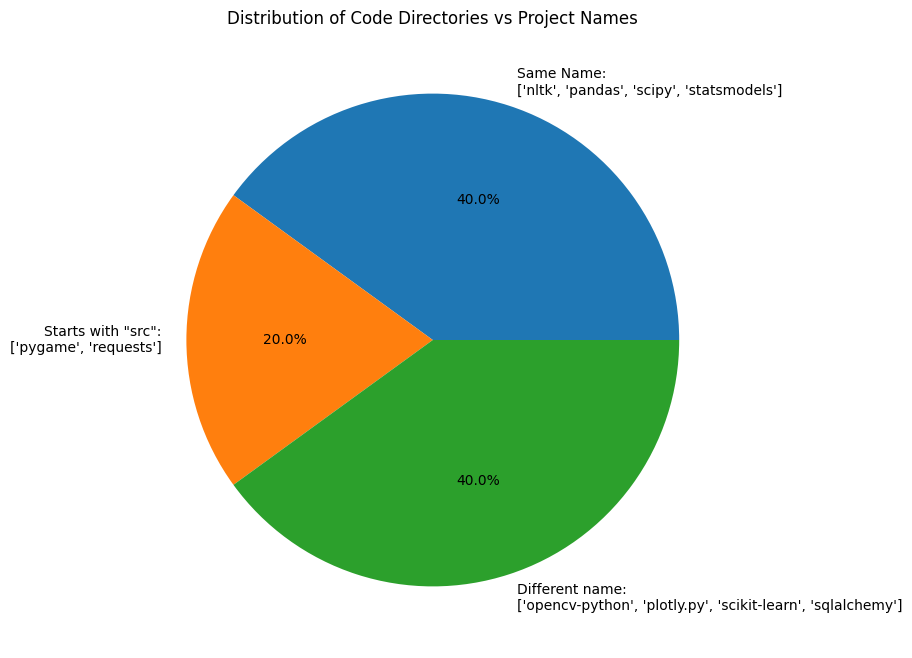

In [6]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Category": ["Same Name", 'Starts with "src"', "Different name"],
        "Percentage": [len(same_name_projects), len(src_projects), len(rest_projects)],
        "Projects": [same_name_projects, src_projects, rest_projects],
    }
)

# Plotting as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}:\n{x['Projects']}", axis=1),
    autopct="%1.1f%%",
)
plt.title("Distribution of Code Directories vs Project Names")
plt.show()

# Dependency declaration files

In [7]:
df_deps

,parser_choice,path,project_name
0,pyproject.toml,pyproject.toml,statsmodels
1,requirements.txt,requirements-dev.txt,statsmodels
2,requirements.txt,requirements-doc.txt,statsmodels
3,requirements.txt,requirements.txt,statsmodels
4,setup.cfg,setup.cfg,statsmodels
...,...,...,...
103,setup.py,setup.py,pandas
104,requirements.txt,requirements-ci.txt,nltk
105,requirements.txt,requirements-test.txt,nltk
106,setup.cfg,setup.cfg,nltk


In [8]:
# Divide projects into three groups by parser choice
project_req_txt = set(
    df_deps[df_deps["parser_choice"] == "requirements.txt"]["project_name"]
)
project_pyproject_toml = set(
    df_deps[df_deps["parser_choice"] == "pyproject.toml"]["project_name"]
)
project_setup = set(
    df_deps[df_deps["parser_choice"].str.startswith("setup")]["project_name"]
)

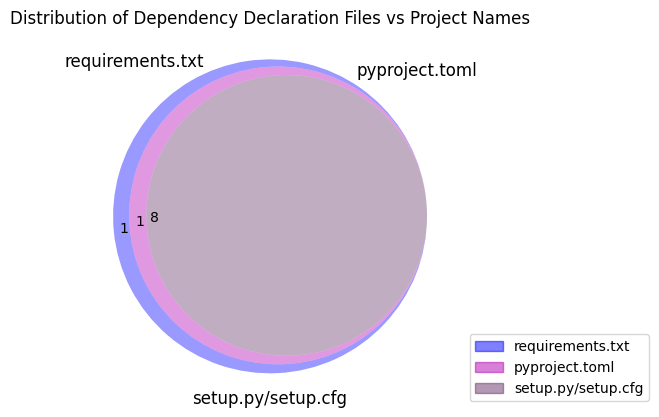

In [9]:
# Draw a venn diagram
plt.figure()
ax = plt.gca()
venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=("requirements.txt", "pyproject.toml", "setup.py/setup.cfg"),
    ax=ax,
)

colors = [patch.get_facecolor() for patch in venn_parsers.patches if patch]

legend_handles = [
    Patch(color=colors[0], alpha=0.5, label="requirements.txt"),
    Patch(color=colors[1], alpha=0.5, label="pyproject.toml"),
    Patch(color=colors[2], alpha=0.5, label="setup.py/setup.cfg"),
]

plt.legend(handles=legend_handles, loc=(1.04, 0))
plt.title("Distribution of Dependency Declaration Files vs Project Names")
plt.show()

# Import patterns

In [10]:
df_imports.head()

,import_type,name,lineno,project_name
0,Docstring,numpy,176,statsmodels
1,Conditional imports,pandas,436,statsmodels
2,Conditional imports,pandas,266,statsmodels
3,Docstring,matplotlib,43,statsmodels
4,Docstring,numpy,43,statsmodels


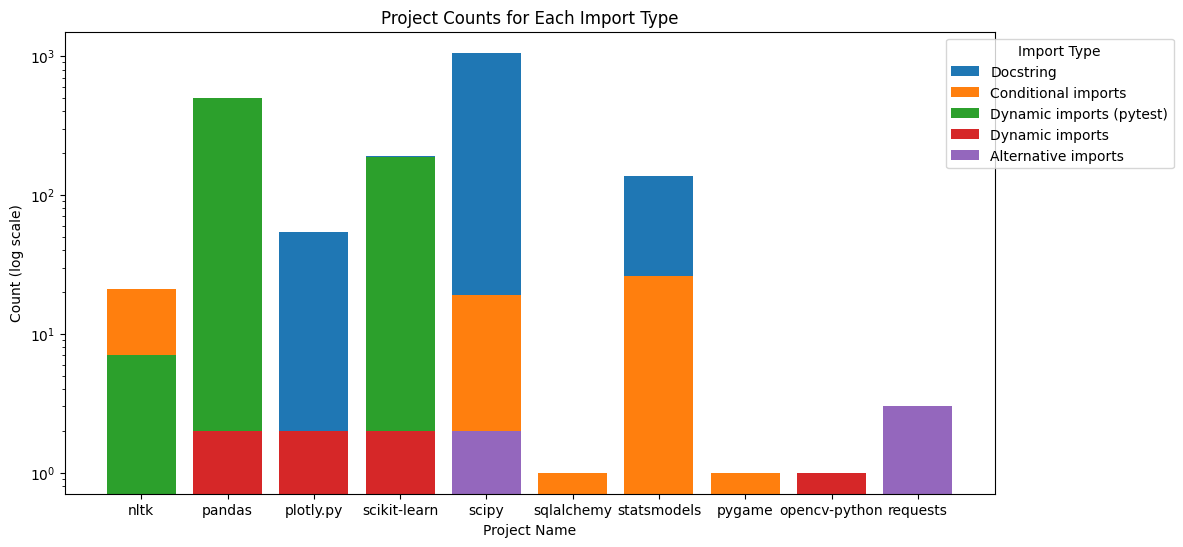

In [11]:
# Create a bar plot for the counts of each import type
plt.figure(figsize=(12, 6))

# Iterate over unique import types and plot a bar for each
for import_type in df_imports["import_type"].unique():
    import_type_data = df_imports[df_imports["import_type"] == import_type]
    project_counts = import_type_data.groupby("project_name").size()
    plt.bar(project_counts.index, project_counts, label=import_type)
    plt.yscale("log")  # Apply log scale to the y-axis for the plot
    plt.ylabel("Count (log scale)")
    plt.title("Project Counts for Each Import Type")
    plt.legend(title="Import Type", loc="upper right", bbox_to_anchor=(1.2, 1))

# Set the common x-axis label
plt.xlabel("Project Name")

plt.show()